In [1]:
## Importing the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import seaborn as sns

In [2]:
## Importing methods from surprise library for recommendation models
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import Dataset, Reader
from surprise import accuracy
from surprise import SVD, KNNWithMeans

In [3]:
## Listing files for input file name
os.listdir()

['.ipynb_checkpoints',
 'Problem Statement - Recommendation Systems.pdf',
 'Rachit_Recommendation_Systems.ipynb',
 'ratings_Electronics.csv']

In [4]:
## Loading the dataset and defining columns as per given case study document
e_ratings=pd.read_csv("ratings_Electronics.csv", names=["userId","productId","ratings","timestamp"])
## Displaying top 5 rows
e_ratings.head(5)

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
## Dropping column timestamp and displaying top 5 rows to verify
e_ratings.drop(columns='timestamp', inplace=True)
e_ratings.head()

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [6]:
## Displaying the dataset information
e_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [7]:
## Displaying the shape of dataset
e_ratings.shape

(7824482, 3)

In [8]:
## Checking for null values
e_ratings.isnull().sum().sum()

0

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: ratings, dtype: int64


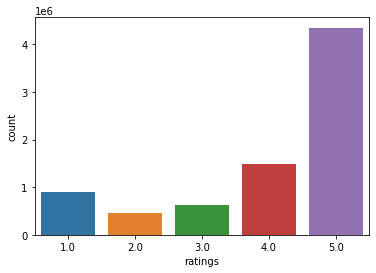

In [9]:
### Displaying the count of records based on ratings
print(e_ratings.ratings.value_counts())
sns.countplot(x=e_ratings.ratings)
plt.show()

It can be seen from the above graph and value counts that 5 ratings has the highest count with over 4.3 million records while 2 ratings has lowest count with only 0.45 million records out of approx 7.8 million records

Now to make data less dense and to create a recommendation model based on popularity and collaborative filtering, we will filter the original dataset according to the following conditions, based on userId as well as productId

In [10]:
## filtering data based on userId ratings by grouping data based on userId 
#Calculating the count and mean of ratings.
user_ratings=pd.DataFrame(e_ratings.groupby('userId')['ratings'].mean())
user_ratings['counts']=pd.DataFrame(e_ratings.groupby('userId')['ratings'].count())

## Filtering out the records with count of user rating less than 50. 
# Only these users will be used in both recommendation models
user_ratings_count=user_ratings[(user_ratings.counts>50)]

## Filtering out users with average ratings less than 3 for popularity.
user_ratings_high=user_ratings_count[(user_ratings_count.ratings>3)]

In [11]:
## Similarly filerting data based on productId ratings by grouping data based on product ID 
## Calculating count and mean of ratings
product_ratings=pd.DataFrame(e_ratings.groupby('productId')['ratings'].mean())
product_ratings['counts']=pd.DataFrame(e_ratings.groupby('productId')['ratings'].count())

## Filtering the products with atleast 100 ratings and mean rating greater than 4
product_ratings_high=product_ratings[(product_ratings.ratings>4) & (product_ratings.counts>100)]

In [12]:
## Creating a dataframe following the 4 conditions:
# mean user ratings greater than 3 and mean product rating greater than 4
# user rating count greater than 50 and product rating count greater than 100
e_ratings_filtered=e_ratings[(e_ratings.userId.isin(user_ratings_high.index)) & 
                              (e_ratings.productId.isin(product_ratings_high.index))]
e_ratings_filtered

,userId,productId,ratings
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1138,A25RTRAPQAJBDJ,0972683275,5.0
3235,A3LDPF5FMB782Z,1400698987,4.0
3296,A2JOPUWVV0XQJ3,1400698987,5.0
...,...,...,...
7821478,A18FLOC8YQY0P8,B00KFAGCUM,5.0
7821514,A3LPL35P7FH78Y,B00KFAGCUM,5.0
7821525,AR3EVUQF0AC7R,B00KFAGCUM,4.0
7821544,A3AVJCB1ZD6ZY5,B00KFAGCUM,5.0


In [13]:
## For the above filtered dataframe, finding the top rated products based on mean ratings
N=10
top_n_popular_products=e_ratings_filtered.groupby('productId')['ratings'].mean().sort_values(ascending=False).head(N).index
top_n_popular_products

Index(['0972683275', 'B007ZFSAB4', 'B007V9ZNBY', 'B007VA05HU', 'B0036WT3XO',
       'B0036WT3V6', 'B0036WT3RU', 'B0036WT3P2', 'B0036QL1JY', 'B0036ORCJY'],
      dtype='object', name='productId')

Alternatively, a popularity recommendation model can be created purely using count of userIds that have rated the products. 

#### Case 1: When all records are considered

In [14]:
#Count of userId for each unique productId as recommendation score 
product_data_grouped = e_ratings.groupby('productId').agg({'userId':'count'}).reset_index()
product_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
product_data_grouped.head()

,productId,score
0,0132793040,1
1,0321732944,1
2,0439886341,3
3,0511189877,6
4,0528881469,27


In [15]:
#Sorting the products on recommendation score 
product_data_sort = product_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generating a recommendation rank based upon score 
product_data_sort['Rank'] = product_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = product_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
308398,B0074BW614,18244,1.0
429572,B00DR0PDNE,16454,2.0
327308,B007WTAJTO,14172,3.0
102804,B0019EHU8G,12285,4.0
296625,B006GWO5WK,12226,5.0


#### Case 2: When only users with more than 50 ratings are considered:

In [16]:
#Count of userId for each unique productId as recommendation score 
product_filtered_grouped = e_ratings_filtered.groupby('productId').agg({'userId':'count'}).reset_index()
product_filtered_grouped.rename(columns = {'userId': 'score'},inplace=True)
product_filtered_grouped.head()

,productId,score
0,0972683275,3
1,1400698987,2
2,9983891212,7
3,B00000DM9W,5
4,B00000J061,4


In [17]:
#Sort the products on recommendation score 
product_filtered_sort = product_filtered_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
product_filtered_sort['Rank'] = product_filtered_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = product_filtered_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
2808,B003ES5ZUU,177,1.0
1080,B000N99BBC,163,2.0
4728,B007WTAJTO,155,3.0
3322,B004CLYEDC,117,4.0
2499,B002SZEOLG,107,5.0


### Since these recommendations are independent of users (as seen in df), the same recommendations will be provided to all the users regardless of their preferences, Hence popularity based recommendations

###### Now creating a dataset of users with more than 50 rating count for making original dataset less dense.
The collaborative filtering model will be prepared on this dataset

In [18]:
## Dataset with users having more than 50 rating records.
e_ratings_filtered_users=e_ratings[(e_ratings.userId.isin(user_ratings_count.index))]
e_ratings_filtered_users

,userId,productId,ratings
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0
...,...,...,...
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824427,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0
7824436,A3AYSYSLHU26U9,B00LI4ZZO8,4.0
7824438,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0


In [19]:
## Defining reader and data using Reader and Dataset from surprise library to create surprise dataframes for recommender models
reader = Reader()
data=Dataset.load_from_df(e_ratings_filtered_users,reader)

In [20]:
## Visualising the data dataframe
data.df

,userId,productId,ratings
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0
...,...,...,...
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824427,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0
7824436,A3AYSYSLHU26U9,B00LI4ZZO8,4.0
7824438,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0


In [21]:
## Splitting the dataset into train and test in 70:30 ratio
trainset, testset = train_test_split(data, test_size=0.3)

For item-item collaborative model, the dataset size is very large, so we will randomly select 10K records out of the above original filtered dataset for creating item-item collaborative model

In [22]:
## Randomly selecting 10k records and defining the data_sample surprise dataframe.
e_ratings_filtered_users_sample=e_ratings_filtered_users.sample(n=10000,random_state=10)
data_sample=Dataset.load_from_df(e_ratings_filtered_users_sample,reader)
## Splitting the sampled surprise df into 70:30 train test ratio for model.
train_sample, test_sample = train_test_split(data_sample, test_size=0.3)

In [23]:
## fitting the data on knnwithmeans model with user-based option set to false, enabling item-item collaborative filtering.
item_item=KNNWithMeans(k=5,sim_options={'name': 'pearson_baseline', 'user_based': False},random_state=10)
item_item.fit(train_sample)
test_pred_item = item_item.test(test_sample)

## calculating the rmse score for item-item collaborative filtering
accuracy.rmse(test_pred_item)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.1175


1.1174754104515836

For item-based collaborative filtering model, the RMSE score is 1.15

In [24]:
### Now fitting the original trainset on SVD model
svd_model = SVD(n_factors=5,biased=False, random_state=10)
svd_model.fit(trainset)
test_pred = svd_model.test(testset)
## Calculating the RMSE score
accuracy.rmse(test_pred)

RMSE: 1.6206


1.6205852525325692

For SVD collaborative filtering, the RMSE score is 1.66

In [25]:
## Finally fitting the original trainset on KNNWithMeans model having user-based option set, enabling user-based filtering
user_user = KNNWithMeans(k=5,sim_options={'name': 'pearson_baseline', 'user_based': True},random_state=10)
user_user.fit(trainset)
test_pred_user = user_user.test(testset)
## Calculating the RMSE score
accuracy.rmse(test_pred_user)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0502


1.0502309486150816

For user-based collaborative filtering model, the RMSE score is 1.05 

#### Since the RMSE score is least for user-based collaborative filtering, we will use the prediction dataset based on it for recommending products

In [26]:
## creating test set dataframe for recommending products
pred = pd.DataFrame(test_pred_user)
pred.head()

,uid,iid,r_ui,est,details
0,A8CKH8XB33XGN,B006LFK16Q,4.0,4.260609,"{'was_impossible': True, 'reason': 'User and/o..."
1,A2I357I10ZY7CI,B005ONMDYE,4.0,5.000000,"{'actual_k': 1, 'was_impossible': False}"
2,A1ZCSSCAGBCD49,B005KQ2O26,5.0,3.570637,"{'actual_k': 1, 'was_impossible': False}"
3,A335QXPTV1RIV1,B001FSEXRC,5.0,4.260609,"{'was_impossible': True, 'reason': 'User and/o..."
4,A18OTCHQ6MXD6X,B004WO8HQ4,5.0,4.354167,"{'actual_k': 0, 'was_impossible': False}"


In [27]:
## creating function to recommend top 5 products based on user id
def top_5_recommendations(uid):
    print("Top 5 recommended productId for userId:",uid)
    print(pred[pred['uid'] == uid ][['iid', 'r_ui']].sort_values(by = 'r_ui',ascending = False).head(5)['iid'])

In [28]:
## Displaying the top 5 product recommendations for randomly selected 3 users
for i in e_ratings_filtered_users.userId.sample(n=3).tolist():
    top_5_recommendations(i)

Top 5 recommended productId for userId: A1JUBRIZMO0RJV
2512     B000BNNGUC
13530    B002Q0W82A
19559    B000932AMO
4099     B001FA1NEG
17290    B001F7AHXW
Name: iid, dtype: object
Top 5 recommended productId for userId: A2I357I10ZY7CI
35406    B002ZV6U1A
14445    B0079M711S
21064    B001TH7GUK
20635    B002BOX230
26173    B004FLESGW
Name: iid, dtype: object
Top 5 recommended productId for userId: A27QXQQOLAMRRR
14071    B0009O6IXA
9631     B0002YE6EU
33871    B000GGQCIM
27153    B000FNBYKW
22452    B00J238GV6
Name: iid, dtype: object


In [29]:
## Displaying top 5 recommendation for a specific user
userID='A10H24TDLK2VDP'
top_5_recommendations(userID)

Top 5 recommended productId for userId: A10H24TDLK2VDP
16903    B00FG38L16
25313    B000FVZC66
5231     B00BOHNYU6
6703     B0007RB280
6782     B009Z7KMUM
Name: iid, dtype: object


#### Insights:

1. Popularity based recommendation systems are not personalised and the recommendations are usually based on frequency of user ratings. The model can be altered to consist of only specific users and high mean ratings, but the recommendations would remain same for all users once the model is set.

2. Collaborative filering models are based on past user behavior vis similarity in user profiles or similarity in item choices. Here the User-based collaborative filering model had the lowest RMSE score followed by item-based collaborative filtering model and then SVD model.

3. The recommendations predicted by collaborative filtering model are personalised and dependent on user and its past behaviour. No additional information is required in this case.